In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# 找出违约的Y

### 确定阶段M

用户逾期详情表

In [2]:
df_Credit=pd.read_csv('F:/temdata/data/CreditSampleWindow.csv')

In [3]:
df_Credit.head()

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE
0,CID0128273,,M0,20170701.0,20170703.0
1,CID0214787,,M0,20180201.0,20180204.0
2,CID0287932,M4,M5,20180501.0,20180531.0
3,CID0351850,,M0,20161002.0,20161005.0
4,CID0217310,,M0,20150601.0,20150602.0


In [ ]:
df_Credit.START_DATE=pd.to_datetime(df_Credit.START_DATE)
df_Credit.CLOSE_DATE=pd.to_datetime(df_Credit.CLOSE_DATE)

In [45]:
df_Credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813157 entries, 0 to 1813156
Data columns (total 5 columns):
CID           object
STAGE_BEF     object
STAGE_AFT     object
START_DATE    datetime64[ns]
CLOSE_DATE    datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 69.2+ MB


In [29]:
df_Credit.shape

(1813157, 5)

In [4]:
df_Credit.isnull().sum()/df_Credit.shape[0]

CID           0.000000
STAGE_BEF     0.082451
STAGE_AFT     0.082451
START_DATE    0.082451
CLOSE_DATE    0.082451
dtype: float64

缺失比例一致说明是没有逾期的流水

In [5]:
#数据从业务意义上来讲，不允许重复，删除重复行
df_Credit.drop_duplicates(inplace=True)
df_Credit.shape

(1813157, 5)

CID:用户ID,每逾期一次，id出现一次    
STAGE_BEF:本阶段前的逾期阶段，有空值和空格，需要参考后边日期处理，空值是指没有过违规行为，空格是指之前没有，但本阶段开始违约。       
STAGE_AFT:本阶段进入的逾期阶段，有空值，是没有违约过的。 
START_DATE:进入本阶段时间,有空值，是没有违约过的    
CLOSE_DATE:本阶段结束时间，有空值，是没有违约过的    
M0: 逾期 0-3 天   
M1: 逾期 3-30 天  
M2: 逾期 30-60 天  
M3: 逾期 60-90 天  
以此类推       

In [6]:
# 去除没有逾期阶段记录的信息
df_Credit.dropna(subset=['STAGE_BEF','STAGE_AFT'], inplace=True)
df_Credit.shape

(1663660, 5)

取每个 ID 每个月份内的最高逾期记录作为该月份的逾期指标，记录中只有从低阶段到高阶段的记
录，因此用 _AFT 字段作为该月的指标。

In [7]:
#提取月份信息
df_Credit["START_MONTH"] = df_Credit.START_DATE.apply(lambda x: int(x//100))
df_Credit["CLOSE_MONTH"] = df_Credit.CLOSE_DATE.apply(lambda x: int(x//100))

In [8]:
#提取阶段信息
df_Credit["AFT_FLAG"] = df_Credit.STAGE_AFT.apply(lambda x: int(x[-1]))

In [9]:
df_Credit.head()

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
0,CID0128273,,M0,20170701.0,20170703.0,201707,201707,0
1,CID0214787,,M0,20180201.0,20180204.0,201802,201802,0
2,CID0287932,M4,M5,20180501.0,20180531.0,201805,201805,5
3,CID0351850,,M0,20161002.0,20161005.0,201610,201610,0
4,CID0217310,,M0,20150601.0,20150602.0,201506,201506,0


In [11]:
#df_Credit.START_MONTH.value_counts(sort=False,dropna=False)
df_Credit.CLOSE_MONTH.value_counts(sort=False,dropna=False)

0          28364
201802     82058
201803    113132
201801     86811
201804     87754
201805     96959
201506      4780
201507      7541
201504      1847
201505      3807
201510     14021
201511     14733
201508      8513
201509     10437
201512     19321
201503      1231
201702     44791
201703     62956
201701     45879
201706     53745
201707     65599
201704     47828
201705     59899
201710     75386
201711     71327
201708     60008
201709     65008
201712     90765
201602     19493
201603     24377
201601     18860
201606     23615
201607     31242
201604     21096
201605     25883
201610     37562
201611     35642
201608     30939
201609     30716
201612     39735
Name: CLOSE_MONTH, dtype: int64

In [12]:
# 将 CLOSE_DATE 为空的数据填补为 201805，取值的时候还没有结束。（根据数据缺失的业务背景确定）
df_Credit.loc[df_Credit.CLOSE_MONTH == 0,"CLOSE_MONTH"] = 201805

生成单个订单的流水

In [14]:
 # 提取 ID、月份、月份对应状态作为新的数据
#这个月的开始即上个月的结束，故将元数据拆分成两部分合并
#这样做主要解决的是如M0和M1发生在同一个月，那么就取最大的那个值
overdue_1= df_Credit.loc[:,["CID","START_MONTH","AFT_FLAG"]]\
    .rename(columns={"START_MONTH":"CLOSE_MONTH"})\
    .append(df_Credit.loc[:,["CID","CLOSE_MONTH","AFT_FLAG"]],
    ignore_index=True)

In [15]:
# 生成每个订单的逾期信息
#只保留当月最高记录
overdue = overdue_1.sort_values(by=["CID","CLOSE_MONTH","AFT_FLAG"])\
    .drop_duplicates(subset=["CID","CLOSE_MONTH"],keep="last")\#重复项中保留最后一次记录
    .set_index(["CID","CLOSE_MONTH"]).unstack(1)#长表变宽表

In [19]:
overdue.columns = overdue.columns.droplevel()
overdue.head()

CLOSE_MONTH,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,...,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805
CID,,,,,,,,,,,,,,,,,,,,,
CID0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CID0000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CID0000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
CID0000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,NaN
CID0000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [21]:
import collections

构建转移矩阵，横坐标（行）表示转移前状态，纵坐标（列）表示下一个月状态（转移后）, 选取
连续两个月的有记录的，记录逾期阶段迁移，计算 count 录入转移矩阵。

In [25]:
import collections
def get_mat(df):
    """
    构建转移矩阵，索引表示转移前的逾期状态，
    列名表示转移后的逾期状态。
    """
    #先生成一个矩阵
    trans_mat = pd.DataFrame(data=0, columns=range(0,10),index=range(0,10))
    counter = collections.Counter()#建一个计数器，能够对传进去序列的子元素进行计数

    for i,j in zip(df.columns,df.columns[1:]):#将上个月与下个月拼接
        select = (df[i].notnull()) & (df[j].notnull())#上月和下月都有记录的，第i列和第j列不为空的值
        counter += collections.Counter(tuple(x) for x in df.loc[select, [i,j]].values)
        #第i列和第j列不为空的行的值

    for key in counter.keys():
        trans_mat.loc[key[0],key[1]] = counter[key]
      #转换为所建矩阵形式  
    trans_mat["all_count"] = trans_mat.apply(sum, axis=1)
    bad_count = []
    for j in range(10):
        bad_count.append(trans_mat.iloc[j,j+1:10].sum())
    trans_mat["bad_count"] = bad_count
    trans_mat["to_bad"] = trans_mat["bad_count"]/trans_mat["all_count"]
    return trans_mat

In [23]:
collections.Counter([(1,0),(0,1),(1,1),(1,0)])

Counter({(1, 0): 2, (0, 1): 1, (1, 1): 1})

In [26]:
#注意：因为异常点不多，不影响整体结果，故不处理
get_mat(overdue)

,0,1,2,3,4,5,6,7,8,9,all_count,bad_count,to_bad
0,218269,78639,3232,0,0,0,0,0,2,2,300144,81875,0.272786
1,59218,169811,20351,9020,0,16,8,8,2,6,258440,29411,0.113802
2,556,4061,3775,17287,7,0,0,0,0,0,25686,17294,0.673285
3,184,1233,586,1686,22226,446,0,0,0,2,26363,22674,0.860069
4,1,20,5,0,233,13634,2803,8,0,0,16704,16445,0.984495
5,0,2,2,0,0,211,14936,911,0,0,16062,15847,0.986614
6,0,0,0,2,0,0,179,17223,9,8,17421,17240,0.989610
7,0,8,0,0,8,0,8,1292,14262,4,15582,14266,0.915544
8,2,2,0,0,0,0,2,4,98,12527,12635,12527,0.991452
9,0,10,2,4,0,4,8,12,22,247,309,0,0.000000


由上表可知， 在逾期阶段到了 M2 时，下一阶段继续转坏的概率达到了 67%，逾期阶段到达 M3 阶
段时，下一阶段继续转坏的概率为 86%，可根据业务需要（营销、风险等等）来考虑定义进入 M2 或
M3 阶段的用户为坏客户。这里我们暂定为 M2。

### 确定时间间隔

In [28]:
first_use=pd.read_csv('F:/temdata/data/CreditFirstUse.csv')
first_use.head(3)

,CID,FST_USE_DT
0,CID0092102,20161116
1,CID0111878,20161118
2,CID0264977,20161120


In [29]:
first_use.set_index("CID",inplace=True)

In [30]:
first_use["FST_USE_MONTH"] = first_use.FST_USE_DT.map(lambda x:x//100)
first_use.head()

,FST_USE_DT,FST_USE_MONTH
CID,,
CID0092102,20161116,201611
CID0111878,20161118,201611
CID0264977,20161120,201611
CID0059996,20160907,201609
CID0057096,20160910,201609


In [31]:
# 计算每笔订单第一次出现逾期的月份索引位置
def get_first_overdue(ser):
    array = np.where(ser >= 2)[0]
    if array.size > 0:
        return array[0]
    else:
        return np.nan

In [59]:
OVERDUE_INDEX = overdue.apply(get_first_overdue,axis=1)
# 用时约 1 ～ 2 分钟

In [33]:
first_use["OVERDUE_INDEX"] = OVERDUE_INDEX

In [34]:
first_use["START_INDEX"] = first_use.FST_USE_MONTH.map({k:v for v,k in enumerate(overdue.columns)})
#enumerate（）返回索引及数据，然后对每个值去集合里查对应值

In [35]:
first_use.loc[first_use.OVERDUE_INDEX.notnull()].head()

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,
CID0082006,20160906,201609,26.0,18.0
CID0383647,20160906,201609,29.0,18.0
CID0006192,20161022,201610,28.0,19.0
CID0348120,20161122,201611,33.0,20.0
CID0155834,20161123,201611,28.0,20.0


In [36]:
# 查看异常数据
first_use[first_use.OVERDUE_INDEX < first_use.START_INDEX]

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,
CID0164451,20170722,201707,9.0,28.0


In [39]:
df_Credit.loc[df_Credit.CID=="CID0164451",:]

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
1115857,CID0164451,M1,M2,20151201.0,20151225.0,201512,201512,2
1298974,CID0164451,,M0,20151101.0,20151104.0,201511,201511,0
1462710,CID0164451,M0,M1,20151104.0,20151201.0,201511,201512,1
1796143,CID0164451,,M0,20170101.0,20170102.0,201701,201701,0


In [40]:
# 仅有一条处理时删除即可
month_count = (first_use.OVERDUE_INDEX - first_use.START_INDEX).value_counts().sort_index()[1:]


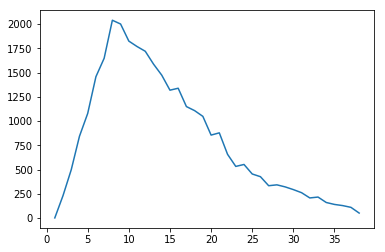

In [43]:
month_count.plot()
plt.show()

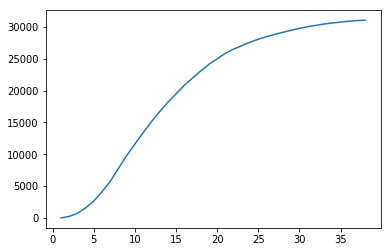

In [42]:
#累积图
month_count.cumsum().plot();
#用分号使得对象信息不显示，类似于plt.show()
#在20个月的时候减缓，但实际银行是按6个月出现m3算的

正负样本定义实例：如果通过分析判断观察时间窗口为 m2 表现时间窗口为 6 个月， 那么则定义首
六期内有 m2 及以上逾期，即逾期天数 >= 31 天的样本为负样本，逾期天数 <= 3 天的样本为正样本，中
间状态的样本做不确定处理不进入模型。

# 模型预测

用户申请信息表

In [2]:
train=pd.read_csv('F:/temdata/data/cs-training.csv',index_col=0)
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [75]:
#查看缺失比例
#train.isnull().mean()
train.notnull().sum()/train.shape[0]

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    1.000000
age                                     1.000000
NumberOfTime30-59DaysPastDueNotWorse    1.000000
DebtRatio                               1.000000
MonthlyIncome                           0.804399
NumberOfOpenCreditLinesAndLoans         1.000000
NumberOfTimes90DaysLate                 1.000000
NumberRealEstateLoansOrLines            1.000000
NumberOfTime60-89DaysPastDueNotWorse    1.000000
NumberOfDependents                      0.974376
dtype: float64

In [67]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [3]:
#删除重复项
train.drop_duplicates(inplace=True)

SeriousDlqin2yrs:出现 90 天或更长时间的逾期行为（即定义好坏客户）,二分类变量Y/S。  
RevolvingUtilizationOfUnsecuredLines：贷款以及信用卡可用额度与总额度比例，百分比。***有异常值需要处理，应该是没有除以总额度的原因。***  
age：借款人借款年龄，整数。最小年龄为0，最大年龄为109，***有异常值，需要处理。最后要转化为代表年龄段的数值变量***  
NumberOfTime30-59DaysPastDueNotWorse:过去两年内出现35-59天逾期但是没有发展的更坏的次数，整数。***有个最大值98，不知道对不对，感觉不对***  
DebtRatio：每月偿还债务，赡养费，生活费用除以月总收入，百分比。***有异常值需要处理，应该是没有除以月总收入的原因。***  
MonthlyIncome：月收入，真实值。***有缺失值，在0到三百万之间，要处理异常值***  
NumberOfOpenCreditLinesAndLoans：开放式贷款和信贷数量，整数。***有个最大值58，不知道对不对，感觉不对***  
NumberOfTimes90DaysLate：借款者有90天或更高逾期的次数，整数。***有个最大值98，不知道对不对，感觉不对***  
NumberRealEstateLoansOrLines：抵押贷款和房地产贷款数量，包括房屋净值信贷额度，整数。***有个最大值54，异常值需处理***  
NumberOfTime60-89DaysPastDueNotWorse：过去两年内出现60-89天逾期但是没有发展的更坏的次数，整数。***有个最大值98，不知道对不对，感觉不对***  
NumberOfDependents：家庭中不包括自身的家属人数（配偶，子女等），整数。***实际为浮点型，要处理完空值和异常值之后改回去,而且有一个家庭人数是20，不知道对不对。***  

### 缺失值处理

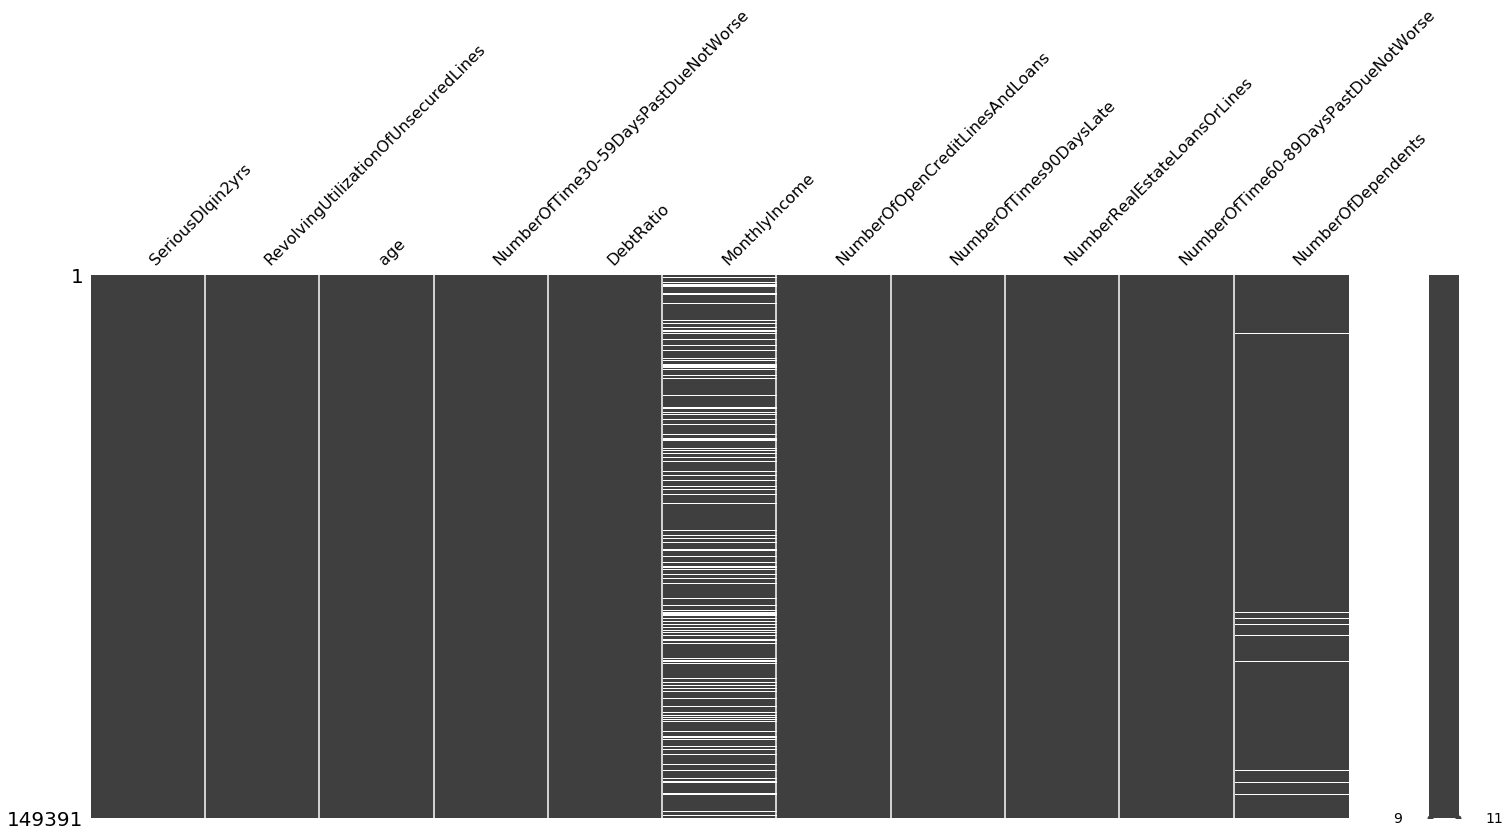

In [74]:
import missingno as msno
msno.matrix(train);

***非海量信息时matrix()可看出缺失的相关程度和隐含关系***

1. 直接删除含有缺失值的样本，尽量不要删，数据量大时，如果要删低于5%  
2. 使用普通的统计方法或根据业务经验填补，经验最为有效。  
3. 将缺失值作为一个单独的独立编码，缺失本身是一种信息。  
4. 使用算法进行填补，实际业务中比较少用，因为新增进来样本后，填充值又会变。    
如果需要较好的可视化缺失值的缺失状况，可以使用绘制缺失值的包来完成：

In [4]:
median = train.MonthlyIncome.median()
median

5400.0

In [5]:
train.MonthlyIncome.fillna(value=median, inplace=True)

***注意：填充是一个定值，median得是一个具体的数***

In [6]:
train_data=train.dropna()#删除比较少的缺失值

NumberOfDependents变量缺失值比较少，直接删除，对总体模型不会造成太大影响。对缺失值处理完之后，删除重复项

In [7]:
train_data.shape

(145563, 11)

In [81]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

### 异常值处理

异常值一般是从统计上看起来异常，但是很多时候并不代表这条数据是错误的，可能只是这条观测
和普遍情况不同而已，处理时需要谨慎。这里举一例 age 字段中包含有为 0 的值，通常认为该值为异常
值，查看数据可以发现仅有一条数据年龄为 0，因此可以直接删除。

In [82]:
train_data.age.value_counts().sort_index()

0         1
21      136
22      340
23      557
24      736
25      898
26     1142
27     1275
28     1516
29     1657
30     1893
31     2012
32     2017
33     2219
34     2121
35     2211
36     2340
37     2480
38     2595
39     2961
40     3052
41     3092
42     3052
43     3182
44     3273
45     3463
46     3656
47     3671
48     3734
49     3779
       ... 
74     1371
75     1164
76     1112
77     1026
78      985
79      908
80      819
81      704
82      592
83      456
84      435
85      431
86      364
87      306
88      263
89      241
90      163
91      122
92       81
93       70
94       35
95       37
96       14
97       12
98        5
99        4
101       3
102       3
103       3
107       1
Name: age, Length: 84, dtype: int64

In [9]:
train_data = train_data.loc[train_data.age>0]

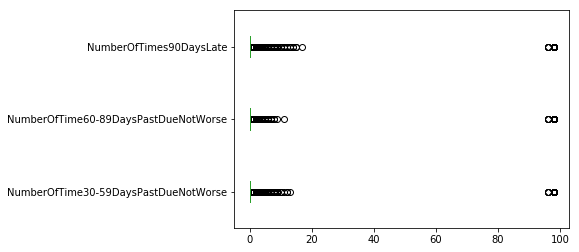

In [10]:
import matplotlib.pyplot as plt
columns = ["NumberOfTime30-59DaysPastDueNotWorse",
"NumberOfTime60-89DaysPastDueNotWorse",
"NumberOfTimes90DaysLate"]
train_data[columns].plot.box(vert=False);

In [11]:
#删除两个异常值
for col in columns:
    train_data = train_data.loc[train_data[col] < 90]

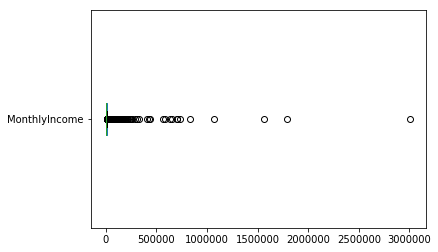

In [12]:
train_data['MonthlyIncome'].plot.box(vert=False);

In [13]:
#删除月收入中两个异常离群点
train_data=train_data[train_data.MonthlyIncome<1500000]

In [100]:
#贷款以及信用卡可用额度与总额度比例
len(train_data[train_data.RevolvingUtilizationOfUnsecuredLines>1])

3260

In [89]:
len(train_data[train_data.DebtRatio>1])

31663

### 数据集划分

In [14]:
from sklearn.model_selection import train_test_split

数据集的划分原则上应当在缺失值和异常值处理之前就进行，也就是说从数据预处理阶段开始， 验
证集和测试集就不应参与到模型构建的各个阶段中来，而应仅使用训练集得到的信息，这样才能有效严
谨的保证模型验证和评估不会出现潜在的过拟合问题。此外，**因为评分卡与其他机器学习略有区别，评
分卡的数据是带有时间因素的而并非单纯的截面数据，因此，在划分数据集的时候，应当使用更早时间
段的数据作为训练集，稍晚和最晚的时间段的数据分别作为验证集和测试集。**同时，合理划分数据集后
应当保证训练集、验证集和测试集和数据分布应当相同。

In [15]:
Y = train_data['SeriousDlqin2yrs']
X = train_data.iloc[:, 1:]
X_train, X_vali, Y_train, Y_vali = train_test_split(X, Y, test_size=0.3,random_state=420)

In [16]:
model_data = pd.concat([Y_train, X_train], axis=1)
vali_data = pd.concat([Y_vali, X_vali], axis=1)

**探索性数据分析**

探索性数据分析是一系列的方法，它的目的就是让你最大化对数据的直觉，了解数据中包含哪些信
息并且不包含哪些信息。为了直观展示通常我们会利用一些基本的图形绘制：直方图、散点图和箱线图
等。少数情况下会使用一些高级图形展示变量之间的关系等等。

In [17]:
model_data["SeriousDlqin2yrs"].value_counts()

0    94906
1     6839
Name: SeriousDlqin2yrs, dtype: int64

样本均衡问题：
欠采样

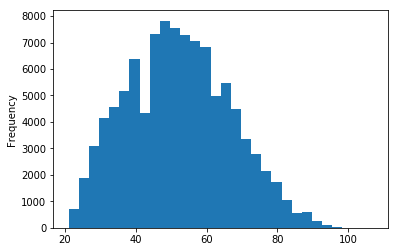

In [18]:
model_data["age"].plot.hist(bins=30);

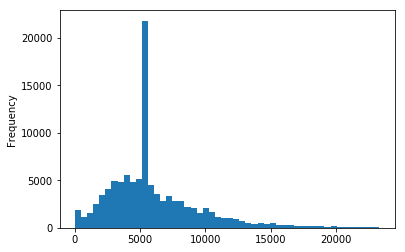

In [113]:
# 可以看出收入有少部分人非常高，使用小于 99% 的分位数的数据查看收入分布
income = model_data["MonthlyIncome"]
income.loc[income < 23334].plot.hist(bins=50);

In [19]:
model_data.corr()#.to_excel("CorrData.xlsx")..相关性高的可以后期留意，先不删除

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001361,-0.112278,0.278020,-0.007087,-0.025051,-0.026755,0.310733,-0.003876,0.265469,0.048276
RevolvingUtilizationOfUnsecuredLines,-0.001361,1.000000,-0.005060,-0.002144,0.004837,0.011522,-0.011967,-0.000871,0.007427,-0.002277,0.003070
age,-0.112278,-0.005060,1.000000,-0.072370,0.030540,0.043104,0.154047,-0.082846,0.039262,-0.070127,-0.216198
NumberOfTime30-59DaysPastDueNotWorse,0.278020,-0.002144,-0.072370,1.000000,0.004762,0.001160,0.075723,0.218165,0.035028,0.303866,0.063386
DebtRatio,-0.007087,0.004837,0.030540,0.004762,1.000000,-0.032970,0.060028,-0.011682,0.135256,-0.003115,-0.052877
MonthlyIncome,-0.025051,0.011522,0.043104,0.001160,-0.032970,1.000000,0.125162,-0.027680,0.171303,-0.013000,0.092605
NumberOfOpenCreditLinesAndLoans,-0.026755,-0.011967,0.154047,0.075723,0.060028,0.125162,1.000000,-0.099074,0.426511,-0.026072,0.062629
NumberOfTimes90DaysLate,0.310733,-0.000871,-0.082846,0.218165,-0.011682,-0.027680,-0.099074,1.000000,-0.068220,0.285840,0.030681
NumberRealEstateLoansOrLines,-0.003876,0.007427,0.039262,0.035028,0.135256,0.171303,0.426511,-0.068220,1.000000,-0.023944,0.122187
NumberOfTime60-89DaysPastDueNotWorse,0.265469,-0.002277,-0.070127,0.303866,-0.003115,-0.013000,-0.026072,0.285840,-0.023944,1.000000,0.036948


**对数据进行分箱**

分箱一般原则：  
• 组间差异大  
• 组内差异小  
• 每组占比不低于 5%  
• 必须有好、坏两种分类  

WOE对分箱后的每组进行计算  
IV衡量的是某一个变量的信息量

In [20]:
from auto_bin1 import AutoBins

In [21]:
bins_data = AutoBins(model_data, "SeriousDlqin2yrs")

In [27]:
# 分析过程中手动完成分箱个数的添加
bins_num = {
"RevolvingUtilizationOfUnsecuredLines":5,
"age":4,
"NumberOfTime30-59DaysPastDueNotWorse":3,
"DebtRatio":5,
"MonthlyIncome":6,
"NumberOfOpenCreditLinesAndLoans":4,
"NumberOfTimes90DaysLate":2,
"NumberRealEstateLoansOrLines":4,
"NumberOfTime60-89DaysPastDueNotWorse":2,
"NumberOfDependents":4,
}

In [25]:
# 通过下面的函数来完成分箱个数的判断 箱体是前开后闭
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfTime30-59DaysPastDueNotWorse",n=2)

对 NumberOfTime30-59DaysPastDueNotWorse 列进行分箱: 
分组个数: 03 	iv值: 0.7194233444389856
分组个数: 02 	iv值: 0.6455296974515246

最后分箱情况: 
分组个数: 02 	iv值: 0.6455296974515246

分组woe情况：
        min       max  count_0  count_1  total  percentage  bad_rate       woe
0      -inf  0.000000    81925     3469  85394    0.839294  0.040623  0.531692
1  0.000000       inf    12981     3370  16351    0.160706  0.206104 -1.281671


In [ ]:
pd.cut(model_data["NumberOfTime30-59DaysPastDueNotWorse"],q=20)

In [29]:
info_values = {}
woe_values = {}
bins_values = {}
for key in bins_num:
    num_bins, woe_df, iv = bins_data.auto_bins(key, n=bins_num[key], show_iv=False)
    info_values[key] = iv
    woe_values[key] = woe_df
    bins_values[key] = [x[0] for x in num_bins] + [float("inf")]

对 RevolvingUtilizationOfUnsecuredLines 列进行分箱: 
对 age 列进行分箱: 
对 NumberOfTime30-59DaysPastDueNotWorse 列进行分箱: 
对 DebtRatio 列进行分箱: 
对 MonthlyIncome 列进行分箱: 
对 NumberOfOpenCreditLinesAndLoans 列进行分箱: 
对 NumberOfTimes90DaysLate 列进行分箱: 
对 NumberRealEstateLoansOrLines 列进行分箱: 
对 NumberOfTime60-89DaysPastDueNotWorse 列进行分箱: 
对 NumberOfDependents 列进行分箱: 


In [30]:
info_values

{'RevolvingUtilizationOfUnsecuredLines': 1.0858584698176401,
 'age': 0.23555901370702903,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.7194233444389856,
 'DebtRatio': 0.0651398297149175,
 'MonthlyIncome': 0.06616353270349919,
 'NumberOfOpenCreditLinesAndLoans': 0.07003825591078296,
 'NumberOfTimes90DaysLate': 0.7879473299200853,
 'NumberRealEstateLoansOrLines': 0.05528288857917417,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.526035654576219,
 'NumberOfDependents': 0.03569085553468077}

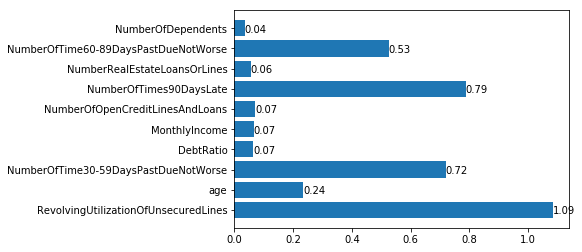

In [33]:
def plt_iv(info_values):
    keys,values = zip(*info_values.items())
    nums = range(len(keys))
    plt.barh(nums,values)
    plt.yticks(nums,keys)
    for i, v in enumerate(values):
        plt.text(v, i-.2, f"{v:.2f}")
plt_iv(info_values)

可以看出 NumberRealEstateLoansOrLines 和 NumberOfDependents 变量的 IV 值明显较低，所
以予以删除。 DebtRatio、 MonthlyIncome、 NumberOfOpenCreditLinesAndLoans 等变量可以考虑删
除也可以予以保留。

# 模型构建

In [35]:
model_woe = pd.DataFrame(index=model_data.index)

In [34]:
woe_values['age']#["woe"]

,min,max,count_0,count_1,total,percentage,bad_rate,woe
0,-inf,36.000000,14288,1744,16032,0.157570,0.108782,-0.527007
1,36.000000,56.000000,42920,3715,46635,0.458352,0.079661,-0.183286
2,56.000000,62.000000,13247,706,13953,0.137137,0.050598,0.301666
3,62.000000,inf,24451,674,25125,0.246941,0.026826,0.960951


In [37]:
#分箱做woe转换，而不是用哑变量
for col in bins_values:
    bins = bins_values[col]#取出截取值
    labels = woe_values[col]["woe"]#取出对应woe值
    model_woe[col] = pd.cut(model_data[col], bins, labels=labels).astype(float)

In [38]:
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]

In [39]:
model_woe.head(5)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
51082,0.349300,-0.183286,-0.894148,0.084376,0.068557,0.170780,0.370531,0.214991,0.270129,-0.083189,0
36685,1.216259,0.960951,0.531692,0.084376,0.068557,-0.024203,0.370531,0.214991,0.270129,0.156176,0
81734,-1.079004,-0.527007,0.531692,0.099359,-0.373632,-0.711930,0.370531,-0.224289,0.270129,0.156176,0
52250,1.216259,-0.183286,0.531692,0.099359,0.221996,-0.024203,0.370531,0.214991,0.270129,-0.351673,0
5003,-0.307275,-0.183286,0.531692,0.099359,0.441302,-0.032921,0.370531,-0.224289,0.270129,0.156176,0


model_woe.to_csv('WoeData.csv',encoding="utf8", index=False)

In [40]:
import statsmodels.api as sm
#data = pd.read_csv('WoeData.csv',encoding="utf8")
data=model_woe
# 设置因变量
endog = data['SeriousDlqin2yrs']
X = data.drop(["SeriousDlqin2yrs",
"NumberRealEstateLoansOrLines",
"NumberOfDependents"],axis=1)
# 设置自变量
exog = sm.add_constant(X)
logit = sm.Logit(endog,exog)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.185827
         Iterations 8


In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101745
Model:                          Logit   Df Residuals:                   101736
Method:                           MLE   Df Model:                            8
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                  0.2458
Time:                        11:54:42   Log-Likelihood:                -18907.
converged:                       True   LL-Null:                       -25068.
                                        LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.6048      0.015   -171.288      0.000      -2.635      -2.575
RevolvingUtilizationOfUnsecuredLines    -0.6089      0.015    -41.375      0.000      -0.638      -0.580
age                                     -0.4618      0.033    -14.112      0.000      -0.526      -0.398
NumberOfTime30-59DaysPastDueNotWorse    -0.5491      0.016    -34.648      0.000      -0.580      -0.518
DebtRatio                               -0.6492      0.057    -11.300      0.000      -0.762      -0.537
MonthlyIncome                           -0.2179      0.056     -3.864      0.000      -0.328      -0.107
NumberOfOpenCreditLinesAndLoans         -0.2582      0.052     -4.930      0.000      -0.361      -0.156
NumberOfTimes90DaysLate                 -0.5417      0.014    -38.246      0.000      -0.569      -0.514
NumberOfTime60-89DaysPastDueNotWorse    -0.4081      0.017    -23.350      0.000      -0.442      -0.374
========================================================================================================
"""

# 模型检验

In [42]:
vali_woe = pd.DataFrame(index=vali_data.index)

In [45]:
for col in bins_values:
    bins = bins_values[col]
    labels = woe_values[col]["woe"]#训练集的woe
    vali_woe[col] = pd.cut(vali_data[col], bins, labels=labels).astype(float)

In [46]:
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [47]:
vali_Y = vali_woe['SeriousDlqin2yrs']
vali_X = vali_woe.drop(["SeriousDlqin2yrs","NumberRealEstateLoansOrLines","NumberOfDependents"],axis=1)
vali_exog = sm.add_constant(vali_X)
vali_proba = result.predict(vali_exog)

In [48]:
import scikitplot as skplt

In [49]:
# 预测结果为对应 1 的概率，转换为数组用于绘图
vali_proba_df = pd.DataFrame(vali_proba,columns=[1])
vali_proba_df.insert(0,0,1-vali_proba_df)

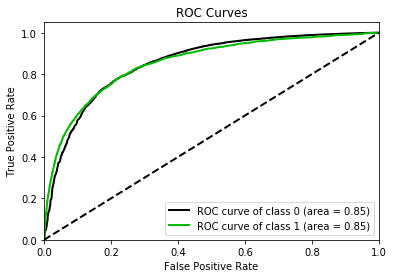

In [50]:
skplt.metrics.plot_roc(vali_Y,vali_proba_df,plot_micro=False,plot_macro=False);

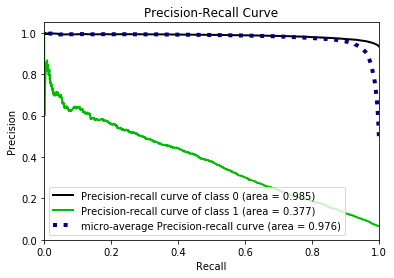

In [51]:
skplt.metrics.plot_precision_recall(vali_Y,vali_proba_df);

# 信用评分

例如：假定比率 Odds 为 1 : 60 时设定的特定分数为 600，PDO = 20 ，那么比率为 1 : 120 时的分
数为 620，代入以上线性表达式，可得：

In [65]:
#自定义一个A、B值
B = 20/np.log(2)
A = 600 + B*np.log(1/60)
A,B

(481.8621880878296, 28.85390081777927)

In [69]:
result.params#系数都为负值的原因是所替换的值，woe越大越接近0

const                                  -2.604756
RevolvingUtilizationOfUnsecuredLines   -0.608890
age                                    -0.461810
NumberOfTime30-59DaysPastDueNotWorse   -0.549133
DebtRatio                              -0.649192
MonthlyIncome                          -0.217943
NumberOfOpenCreditLinesAndLoans        -0.258234
NumberOfTimes90DaysLate                -0.541736
NumberOfTime60-89DaysPastDueNotWorse   -0.408109
dtype: float64

In [67]:
#计算出score中的基础分数A
base_score = A - B*result.params["const"]
base_score

557.0195622201672

In [68]:
# 将评分卡写入文件
# 将评分卡写入文件
file = "ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write(f"base_score,{base_score}\n")
for col in result.params.index[1:]:
    tmp = woe_values[col]
    score = tmp["woe"] * (-B * result.params[col])
    
    score.name = "Score"
    score.index = [
        ("{:.2f}".format(tmp.loc[x, "min"]),
        "{:.2f}".format(tmp.loc[x, "max"])) for x in tmp.index]
    score.index.name = col
    score.to_csv(file,header=True,mode="a")


分箱的woe值一般是单调的，可以有一个拐点，但是不能有多个拐点

In [144]:
name = 'Eric'
f'Hello, my name is {name}'

'Hello, my name is Eric'

In [142]:
name = "Eric"
"Hello, %s." % name

'Hello, Eric.'

In [141]:
name = "Eric"
"Hello, {}. ".format(name)   

'Hello, Eric. '